In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from numpy.polynomial import Polynomial


In [3]:
# Load cleaned data from the processed folder
discharge_meta = pd.read_csv('../nasa_battery_dataset/processed/discharge_meta_with_rul.csv')

## Basic Feature Engineering ##

`Feature Extraction`

Handling feature extraction sepately for each type of files. CSVs files has two type of files. 

1. Type A (Time-Series Data) 
These are typically discharge/charge cycle measurements over time.
2. Type B (Impedance Data)
These give impedance characteristics of the battery at a particular cycle.


### Type A Feature Extraction Code

In [4]:
# Path to your time-series discharge CSV files
data_path = '../nasa_battery_dataset/data/'

csv_files = sorted([f for f in os.listdir(data_path) if f.endswith('.csv')])

# Only use files with Time-Series (Type A) columns
time_series_files = []
for f in csv_files:
    df_sample = pd.read_csv(os.path.join(data_path, f), nrows=1)
    if all(col in df_sample.columns for col in ['Voltage_measured', 'Current_measured', 'Temperature_measured', 'Time']):
        time_series_files.append(f)

# List to store features
time_features_list = []

for file in time_series_files:
    file_path = os.path.join(data_path, file)
    df = pd.read_csv(file_path)

    # Convert Time to seconds
    df['Time'] = pd.to_timedelta(df['Time'])
    duration = (df['Time'].iloc[-1] - df['Time'].iloc[0]).total_seconds()

    # Extract features
    mean_voltage = df['Voltage_measured'].mean()
    max_voltage = df['Voltage_measured'].max()
    min_voltage = df['Voltage_measured'].min()
    std_voltage = df['Voltage_measured'].std()

    mean_current = df['Current_measured'].mean()
    max_current = df['Current_measured'].max()
    min_current = df['Current_measured'].min()
    std_current = df['Current_measured'].std()

    mean_temp = df['Temperature_measured'].mean()
    max_temp = df['Temperature_measured'].max()
    min_temp = df['Temperature_measured'].min()
    std_temp = df['Temperature_measured'].std()

    # Extract cycle number from filename (e.g., '00001.csv' -> 1)
    cycle_number = int(file.replace('.csv', ''))

    time_features_list.append({
        'Cycle': cycle_number,
        'mean_voltage': mean_voltage,
        'max_voltage': max_voltage,
        'min_voltage': min_voltage,
        'std_voltage': std_voltage,
        'mean_current': mean_current,
        'max_current': max_current,
        'min_current': min_current,
        'std_current': std_current,
        'mean_temp': mean_temp,
        'max_temp': max_temp,
        'min_temp': min_temp,
        'std_temp': std_temp,
        'duration': duration
    })




`Creating a Dataframe`

All input features + the target (RUL) for supervised learning.

In [5]:
# Create DataFrame
time_features_df = pd.DataFrame(time_features_list)
# Sort by cycle number
time_features_df.sort_values('Cycle', inplace=True)

# Merge features with RUL
final_time_features_df = pd.merge(time_features_df, discharge_meta[['Cycle', 'RUL']], on='Cycle', how='inner')

# Preview final features
print(final_time_features_df.head())
# save
# final_time_features_df.to_csv('typeA_features_with_rul.csv', index=False)

   Cycle  mean_voltage  max_voltage  min_voltage  std_voltage  mean_current  \
0      1      3.475266     4.246764     2.470612     0.284626     -0.952767   
1      3      4.193521     4.214595     3.486189     0.054022      0.520792   
2      5      3.476559     4.186636     2.477662     0.272495     -0.983889   
3      6      4.187504     4.214574     3.252719     0.074522      0.518686   
4      7      3.470767     4.199923     2.470710     0.278535     -0.983889   

   max_current  min_current  std_current  mean_temp   max_temp  min_temp  \
0     0.000252    -1.001101     0.201448   8.272423  12.376816  5.008084   
1     1.494314     0.001417     0.525708   6.279191   8.793624  4.358202   
2    -0.001536    -0.998142     0.106708   8.210715  11.314903  5.454957   
3     1.495911    -0.002306     0.517950   6.414351  10.145594  4.161258   
4    -0.000746    -1.000307     0.107315   7.954455  11.624528  4.922178   

   std_temp  duration  RUL  
0  1.455269  0.000006    2  
1  1.08053

`Battery Health Dashboard (Time Features)`

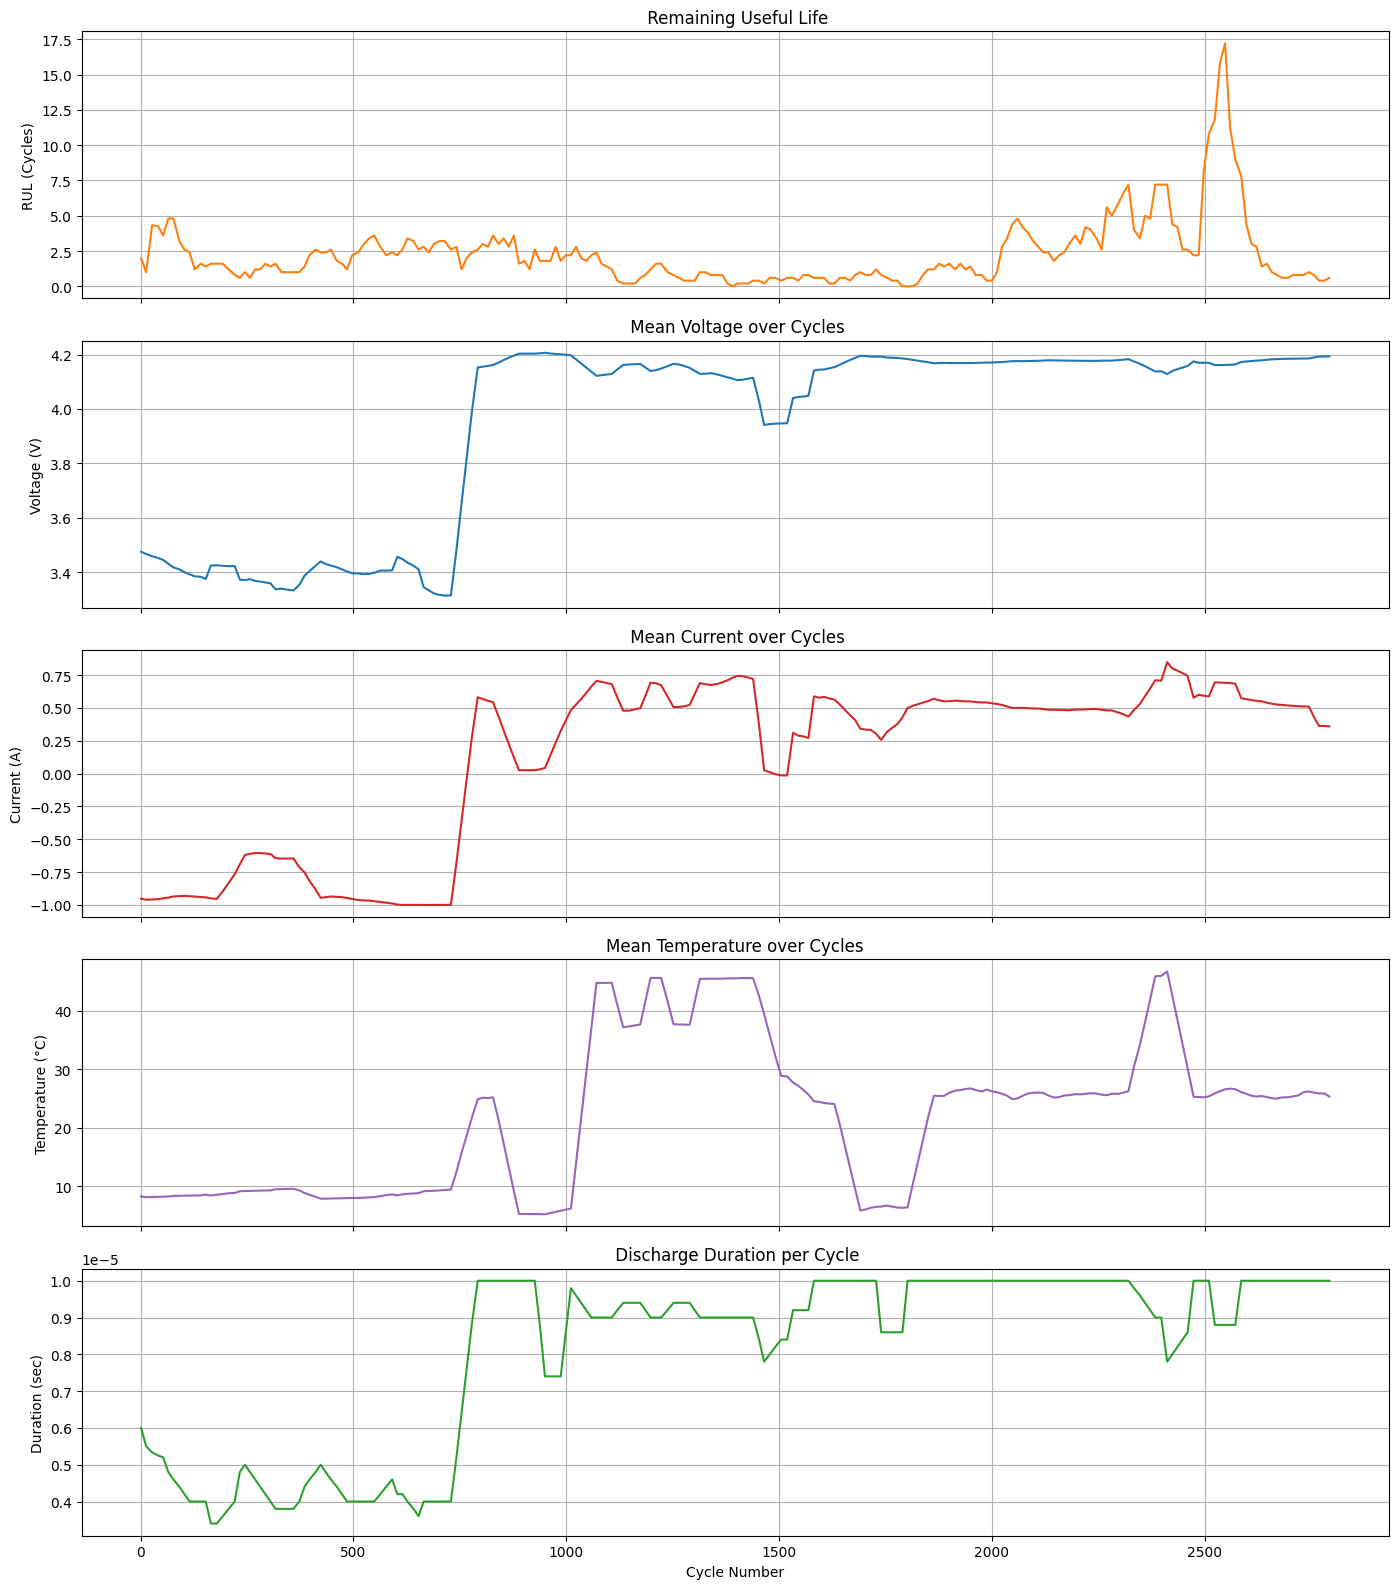

In [6]:
# Plotting the time features

# Make a copy to avoid modifying original
df = final_time_features_df.copy()

# Optional: Sample to reduce plot congestion
df = df.iloc[::10, :].reset_index(drop=True)

# Smooth key features
df['RUL_smooth'] = df['RUL'].rolling(window=5, min_periods=1).mean()
df['mean_voltage_smooth'] = df['mean_voltage'].rolling(window=5, min_periods=1).mean()
df['mean_current_smooth'] = df['mean_current'].rolling(window=5, min_periods=1).mean()
df['mean_temp_smooth'] = df['mean_temp'].rolling(window=5, min_periods=1).mean()
df['duration_smooth'] = df['duration'].rolling(window=5, min_periods=1).mean()

# Create multi-panel dashboard
fig, axs = plt.subplots(5, 1, figsize=(14, 16), sharex=True)

# 1. RUL
axs[0].plot(df['Cycle'], df['RUL_smooth'], color='tab:orange')
axs[0].set_ylabel('RUL (Cycles)')
axs[0].set_title(' Remaining Useful Life')
axs[0].grid(True)

# 2. Mean Voltage
axs[1].plot(df['Cycle'], df['mean_voltage_smooth'], color='tab:blue')
axs[1].set_ylabel('Voltage (V)')
axs[1].set_title(' Mean Voltage over Cycles')
axs[1].grid(True)

# 3. Mean Current
axs[2].plot(df['Cycle'], df['mean_current_smooth'], color='tab:red')
axs[2].set_ylabel('Current (A)')
axs[2].set_title(' Mean Current over Cycles')
axs[2].grid(True)

# 4. Mean Temperature
axs[3].plot(df['Cycle'], df['mean_temp_smooth'], color='tab:purple')
axs[3].set_ylabel('Temperature (°C)')
axs[3].set_title('Mean Temperature over Cycles')
axs[3].grid(True)

# 5. Duration
axs[4].plot(df['Cycle'], df['duration_smooth'], color='tab:green')
axs[4].set_ylabel('Duration (sec)')
axs[4].set_xlabel('Cycle Number')
axs[4].set_title(' Discharge Duration per Cycle')
axs[4].grid(True)

plt.tight_layout()
plt.show()


`Dashboard Graph Explanations`
1. Remaining Useful Life

Shows how many discharge cycle remain before the battery's capacity drops below the usable threshold.

Why: Critical for predicting battery lifespan and planning replacements.



2. Mean Voltage Over Cycles

Displays the average voltage during each discharge cycle, indicating energy output stability as the battery ages.

Why: Voltage drop patterns help identify internal resistance and cell deterioration.



3. Mean Current Over Cycles

Tracks the average current drawn during discharge, reflecting load patterns and potential stress on the battery.

Why: Helps detect abnormal current behavior that may stress battery cells.



4. Mean Temperature Over Cycles

Reveals the battery's thermal behaviour, which can signal overheating or degradation under load.

Why: Temperature spikes can indicate unsafe operating conditions or poor cooling.


5. Discharge During Per Cycles

Shows how long each discharge cycle lasts, which typically decreases as the battery capacity fades.

Why: A shorter duration indicates capacity loss—useful for understanding real-world usage decline.



### Type B Feature Extraction Code

In [7]:

impedance_features_list = []

# Directory containing CSV files
data_folder = "../nasa_battery_dataset/data/"

# Iterate through each CSV file
for file in os.listdir(data_folder):
    if file.endswith('.csv'):
        cycle_number = int(file.replace('.csv', ''))
        df = pd.read_csv(os.path.join(data_folder, file))
        
        # Check if expected columns are present
        if 'Sense_current' in df.columns and 'Battery_current' in df.columns:

            # Convert Sense_current and Battery_current to numeric, if stored as stringified complex numbers
            def parse_complex_column(series):
                return series.apply(lambda x: np.mean([
                    complex(s.strip()) for s in x.strip().replace(')', ')\n').split('\n') if s
                ]).real if isinstance(x, str) else x)

            df['Sense_current'] = parse_complex_column(df['Sense_current'])
            df['Battery_current'] = parse_complex_column(df['Battery_current'])

            # Compute derived feature
            df['Current_ratio'] = df['Battery_current'] / (df['Sense_current'] + 1e-6)

            # Handle impedance columns
            battery_imp = df.get('Battery_impedance', None)
            rect_imp = df.get('Rectified_Impedance', None)

            # Parse complex strings if necessary
            battery_imp_real = parse_complex_column(battery_imp) if battery_imp is not None else []
            rect_imp_real = parse_complex_column(rect_imp) if rect_imp is not None else []

            # Build feature dict
            features = {
                'Cycle': cycle_number,
                'mean_sense_current': df['Sense_current'].mean(),
                'std_sense_current': df['Sense_current'].std(),
                'mean_battery_current': df['Battery_current'].mean(),
                'std_battery_current': df['Battery_current'].std(),
                'mean_current_ratio': df['Current_ratio'].mean(),
                'std_current_ratio': df['Current_ratio'].std(),
                'mean_battery_impedance': np.mean(battery_imp_real) if len(battery_imp_real) else np.nan,
                'std_battery_impedance': np.std(battery_imp_real) if len(battery_imp_real) else np.nan,
                'mean_rectified_impedance': np.mean(rect_imp_real) if len(rect_imp_real) else np.nan,
                'std_rectified_impedance': np.std(rect_imp_real) if len(rect_imp_real) else np.nan
            }

            impedance_features_list.append(features)




`Creating a DataFrame`

All input features + the target (RUL) for supervised learning.

In [8]:

# Convert to DataFrame
impedance_features_df = pd.DataFrame(impedance_features_list)

# Assign even cycle numbers starting from 2 up to the length of your impedance_features_df
impedance_features_df['Cycle'] = list(range(2, 2 * len(impedance_features_df) + 1, 2))

# Sort by cycle number
impedance_features_df.sort_values('Cycle', inplace=True)

# Merge features with RUL
final_impedance_features_df = pd.merge(impedance_features_df, discharge_meta[['Cycle', 'RUL']], on='Cycle', how='inner')


print(final_impedance_features_df.head())

# save
# final_impedance_features_df.to_csv('typeB_features_with_rul.csv', index=False)

   Cycle  mean_sense_current  std_sense_current  mean_battery_current  \
0      2          851.088516          40.267354            299.594052   
1      4          850.385002          33.535733            300.820097   
2      6          855.860001          38.582449            295.020262   
3      8          853.955677          33.179772            296.753834   
4     10          854.198260          39.223210            296.710314   

   std_battery_current  mean_current_ratio  std_current_ratio  \
0            61.025798            0.354937           0.083728   
1            56.456117            0.355783           0.075905   
2            58.770714            0.347290           0.079710   
3            55.349545            0.349373           0.073789   
4            59.661836            0.350055           0.081255   

   mean_battery_impedance  std_battery_impedance  mean_rectified_impedance  \
0                0.206678               0.070205                  0.083600   
1             

`Battery Health Dashboard (Impedance Features)`

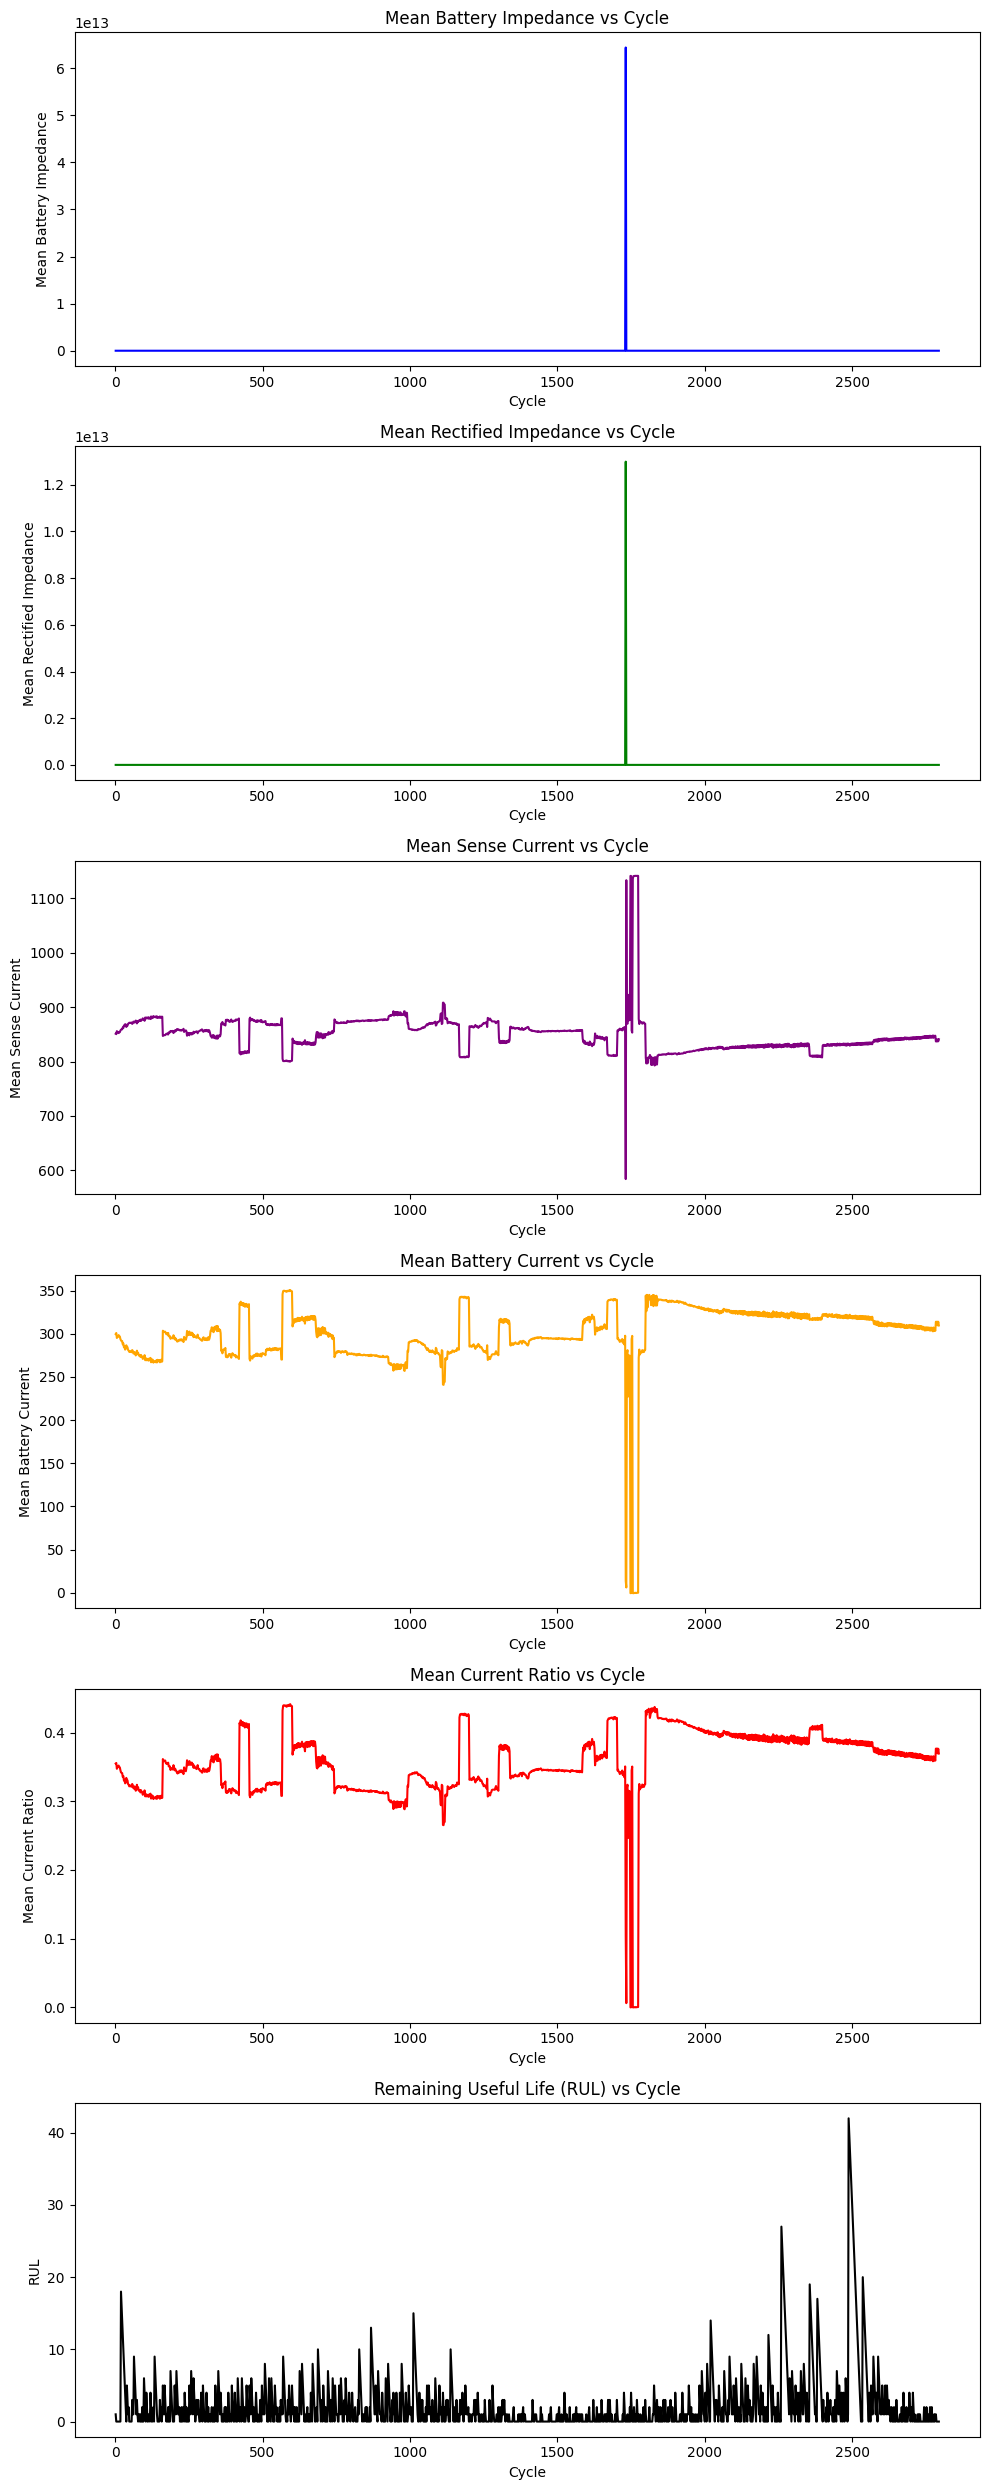

In [9]:
# Plotting the impedance features
# Set figure size
plt.figure(figsize=(10, 25))

# Plot 1: Mean Battery Impedance vs Cycle
plt.subplot(6, 1, 1)
plt.plot(final_impedance_features_df['Cycle'], final_impedance_features_df['mean_battery_impedance'], color='blue')
plt.title('Mean Battery Impedance vs Cycle')
plt.xlabel('Cycle')
plt.ylabel('Mean Battery Impedance')

# Plot 2: Rectified Impedance vs Cycle
plt.subplot(6, 1, 2)
plt.plot(final_impedance_features_df['Cycle'], final_impedance_features_df['mean_rectified_impedance'], color='green')
plt.title('Mean Rectified Impedance vs Cycle')
plt.xlabel('Cycle')
plt.ylabel('Mean Rectified Impedance')

# Plot 3: Mean Sense Current vs Cycle
plt.subplot(6, 1, 3)
plt.plot(final_impedance_features_df['Cycle'], final_impedance_features_df['mean_sense_current'], color='purple')
plt.title('Mean Sense Current vs Cycle')
plt.xlabel('Cycle')
plt.ylabel('Mean Sense Current')

# Plot 4: Mean Battery Current vs Cycle
plt.subplot(6, 1, 4)
plt.plot(final_impedance_features_df['Cycle'], final_impedance_features_df['mean_battery_current'], color='orange')
plt.title('Mean Battery Current vs Cycle')
plt.xlabel('Cycle')
plt.ylabel('Mean Battery Current')

# Plot 5: Mean Current Ratio vs Cycle
plt.subplot(6, 1, 5)
plt.plot(final_impedance_features_df['Cycle'], final_impedance_features_df['mean_current_ratio'], color='red')
plt.title('Mean Current Ratio vs Cycle')
plt.xlabel('Cycle')
plt.ylabel('Mean Current Ratio')

# Plot 6: RUL vs Cycle
plt.subplot(6, 1, 6)
plt.plot(final_impedance_features_df['Cycle'], final_impedance_features_df['RUL'], color='black')
plt.title('Remaining Useful Life (RUL) vs Cycle')
plt.xlabel('Cycle')
plt.ylabel('RUL')

plt.tight_layout()
plt.show()


`Dashboard Graph Explanation`

1. Mean Battery Impedance VS Cycle

Why: Impedance increases as a battery ages.

Insight: Helps detect degradation and internal resistance build-up.

2. Mean Rectifified Impedance VS Cycle

Why: Gives a cleaner or corrected measure of impedance.

Insight: Can highlight subtle degreation not visible in raw impedance. 

3. Mean Sense Current vs Cycle

Why: Shows how much current is being sensed during operation.

Insight: Changes can reflect aging or stress on the battery.

4. Mean Battery Current vs Cycle

Why: Reflects actual current supplied or drawn from the battery.

Insight: Abnormal trends might indicate imbalance, inefficiencies, or stress.

5. Mean Current Ratio vs Cycle

Why: Ratio between different current flows.

Insight: Indicates health of internal circuitry and current control behavior.

6. Remaining Useful Life (RUL) vs Cycle

Why: The most critical health indicator.

Insight: Predicts how many cycles are left before the battery drops below 80% capacity (critical threshold).


## Renaming Columns for Clarity and ML- friendliness

In [10]:
# rename in time features df
time_features_df.rename(columns={
    'mean_voltage': 'voltage_mean',
    'max_voltage': 'voltage_max',
    'min_voltage': 'voltage_min',
    'std_voltage': 'voltage_std',
    'mean_current': 'current_mean_ts',
    'max_current': 'current_max',
    'min_current': 'current_min',
    'std_current': 'current_std_ts',
    'mean_temp': 'temp_mean',
    'max_temp': 'temp_max',
    'min_temp': 'temp_min',
    'std_temp': 'temp_std',
    'duration': 'duration'
}, inplace=True)


In [11]:
# rename in impedance features df
impedance_features_df.rename(columns={
    'mean_sense_current': 'sense_current_mean',
    'std_sense_current': 'sense_current_std',
    'mean_battery_current': 'current_mean',
    'std_battery_current': 'current_std',
    'mean_current_ratio': 'current_ratio_mean',
    'std_current_ratio': 'current_ratio_std',
    'mean_battery_impedance': 'impedance_mean',
    'std_battery_impedance': 'impedance_std',
    'mean_rectified_impedance': 'rectified_impedance_mean',
    'std_rectified_impedance': 'rectified_impedance_std'
}, inplace=True)



## Creating all necessary DataFrame/ Features first

This will ensure both of your feature DataFrames (time_features_df and impedance_features_df) are aligned with the RUL target for modeling.

In [12]:
# Merge time features with RUL
final_time_features_df = pd.merge(time_features_df, discharge_meta[['Cycle', 'RUL']], on='Cycle', how='inner')

# Merge impedance features with RUL
final_impedance_features_df = pd.merge(impedance_features_df, discharge_meta[['Cycle', 'RUL']], on='Cycle', how='inner')


## Advance Feature Engineering

###  1. Degradation Trend Features
#### Capacity Trend - Rate of Capacity Change


In [13]:
# Feature Engineering: Degradation Trend Features
# Sort by Cycle just in case
discharge_meta = discharge_meta.sort_values(by='Cycle')

# Calculate capacity change (delta between current and previous cycle)
discharge_meta['Capacity_Change'] = discharge_meta['Capacity'].diff()

# Rate of capacity change over cycles
discharge_meta['Cycle_Diff'] = discharge_meta['Cycle'].diff()
discharge_meta['Capacity_Change_Rate'] = discharge_meta['Capacity_Change'] / discharge_meta['Cycle_Diff']

# Fill NaNs from diff
discharge_meta[['Capacity_Change', 'Capacity_Change_Rate']] = discharge_meta[['Capacity_Change', 'Capacity_Change_Rate']].fillna(0)


#### Current Trends

In [14]:
impedance_features_df = impedance_features_df.sort_values(by='Cycle')

# Trend: difference in mean current from previous cycle
impedance_features_df['current_trend'] = impedance_features_df['current_mean'].diff().fillna(0)


#### Moving Averages 
` In impedance_features_df`


In [15]:
# Mid and long-term moving averages
for w in [10, 20, 50]:
    impedance_features_df[f'current_ma_{w}'] = impedance_features_df['current_mean'].rolling(window=w).mean().bfill()
    impedance_features_df[f'impedance_ma_{w}'] = impedance_features_df['impedance_mean'].rolling(window=w).mean().bfill()

    time_features_df[f'current_ts_ma_{w}'] = time_features_df['current_mean_ts'].rolling(window=w).mean().bfill()
    time_features_df[f'voltage_ma_{w}'] = time_features_df['voltage_mean'].rolling(window=w).mean().bfill()


`In time_features_df`


In [16]:
# EMA responds quicker to change
for w in [10, 20, 50]:
    impedance_features_df[f'current_ema_{w}'] = impedance_features_df['current_mean'].ewm(span=w, adjust=False).mean()
    impedance_features_df[f'impedance_ema_{w}'] = impedance_features_df['impedance_mean'].ewm(span=w, adjust=False).mean()

    time_features_df[f'current_ts_ema_{w}'] = time_features_df['current_mean_ts'].ewm(span=w, adjust=False).mean()
    time_features_df[f'voltage_ema_{w}'] = time_features_df['voltage_mean'].ewm(span=w, adjust=False).mean()


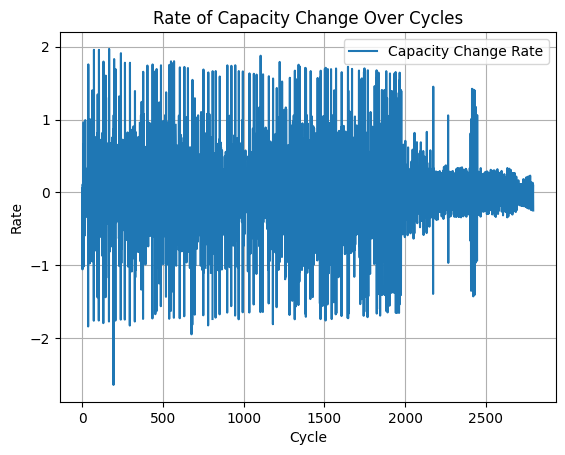

In [17]:
discharge_meta['capacity_change_rate'] = discharge_meta['Capacity'].diff()

plt.plot(discharge_meta['Cycle'], discharge_meta['capacity_change_rate'], label='Capacity Change Rate')
plt.xlabel('Cycle')
plt.ylabel('Rate')
plt.title('Rate of Capacity Change Over Cycles')
plt.legend()
plt.grid(True)
plt.show()


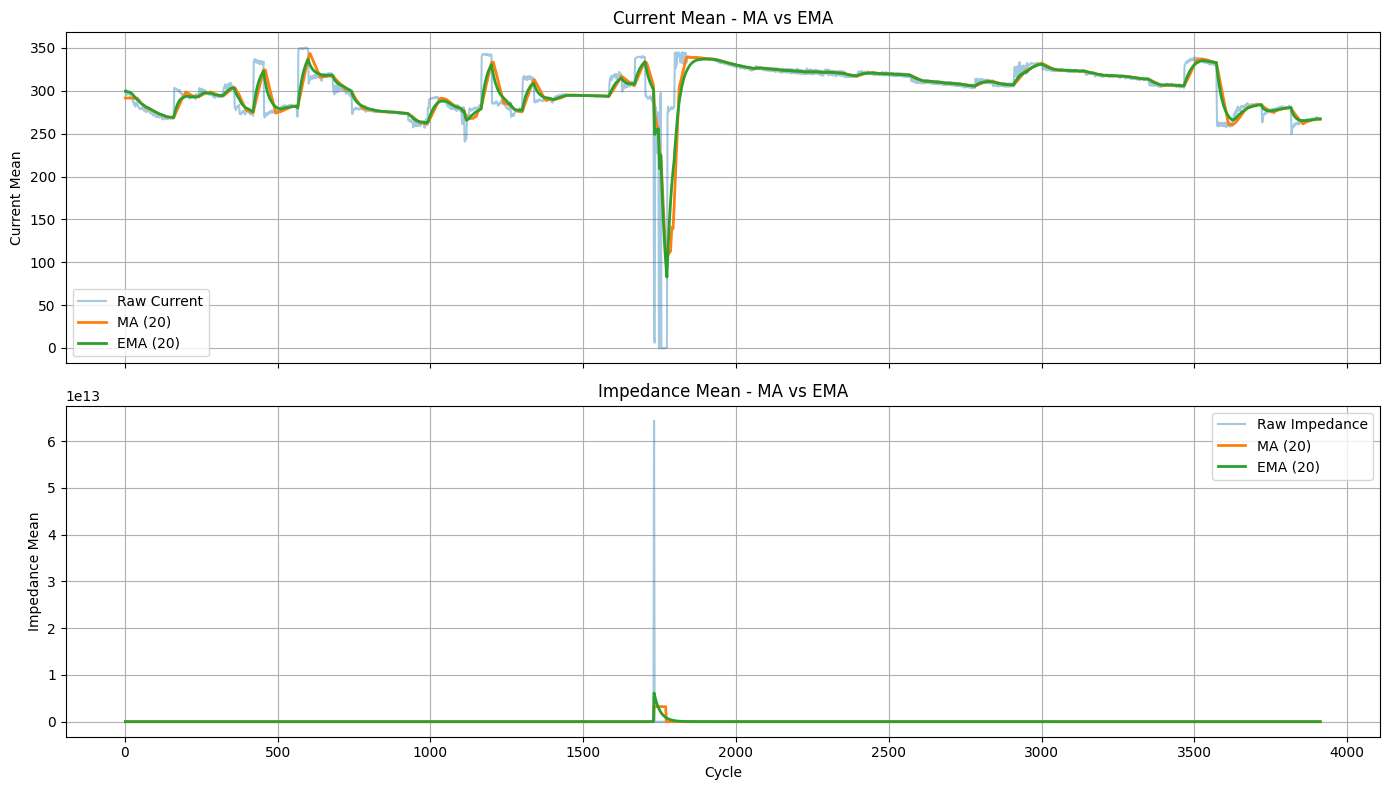

In [18]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Plot 1 - current_mean
axes[0].plot(impedance_features_df['Cycle'], impedance_features_df['current_mean'], label='Raw Current', alpha=0.4)
axes[0].plot(impedance_features_df['Cycle'], impedance_features_df['current_ma_20'], label='MA (20)', linewidth=2)
axes[0].plot(impedance_features_df['Cycle'], impedance_features_df['current_ema_20'], label='EMA (20)', linewidth=2)
axes[0].set_ylabel('Current Mean')
axes[0].set_title('Current Mean - MA vs EMA')
axes[0].legend()
axes[0].grid(True)

# Plot 2 - impedance_mean
axes[1].plot(impedance_features_df['Cycle'], impedance_features_df['impedance_mean'], label='Raw Impedance', alpha=0.4)
axes[1].plot(impedance_features_df['Cycle'], impedance_features_df['impedance_ma_20'], label='MA (20)', linewidth=2)
axes[1].plot(impedance_features_df['Cycle'], impedance_features_df['impedance_ema_20'], label='EMA (20)', linewidth=2)
axes[1].set_xlabel('Cycle')
axes[1].set_ylabel('Impedance Mean')
axes[1].set_title('Impedance Mean - MA vs EMA')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


### 2. Lag Features

These capture how previous cycles influence the current one, which is crucial for modeling battery memory effects.

capacity_lag_1 → previous cycle's capacity

voltage_mean_lag_1 → previous cycle's average voltage

current_mean_lag_1 → previous cycle’s average current

temp_mean_lag_1 → previous cycle’s average temperature

In [19]:
# Assuming 'discharge_meta' and 'time_features_df' are indexed or merged on 'Cycle'
discharge_meta['capacity_lag_1'] = discharge_meta['Capacity'].shift(1)

time_features_df['voltage_mean_lag_1'] = time_features_df['voltage_mean'].shift(1)
time_features_df['current_mean_lag_1'] = time_features_df['current_mean_ts'].shift(1)
time_features_df['temp_mean_lag_1'] = time_features_df['temp_mean'].shift(1)


### 3. Moving Averages & Exponential Smoothing

`These help the model by:`

Smoothing noisy signals

Emphasizing long-term degradation patterns

Reducing sensitivity to small random fluctuations

`We'll calculate:`

Simple Moving Average (SMA) for Capacity, Voltage_mean, etc.

Exponentially Weighted Moving Average (EWMA) (gives more weight to recent values)

In [20]:
# moving averages for capacity in discharge_meta

window_size = 5

discharge_meta['Capacity_MA'] = discharge_meta['Capacity'].rolling(window=window_size, min_periods=1).mean()
discharge_meta['Capacity_EMA'] = discharge_meta['Capacity'].ewm(span=window_size, adjust=False).mean()


In [21]:
#moving averages for voltage and current, time in time_features_df
window_size = 5

for col in ['voltage_mean', 'current_mean_ts', 'temp_mean']:
    time_features_df[f'{col}_MA'] = time_features_df[col].rolling(window=window_size, min_periods=1).mean()
    time_features_df[f'{col}_EMA'] = time_features_df[col].ewm(span=window_size, adjust=False).mean()


#### Rolling Window Stats

In [22]:
# For impedance_features_df
for window in [3, 5, 10]:
    impedance_features_df[f'current_mean_rollmean_{window}'] = impedance_features_df['current_mean'].rolling(window=window).mean()
    impedance_features_df[f'current_mean_rollstd_{window}'] = impedance_features_df['current_mean'].rolling(window=window).std()
    impedance_features_df[f'impedance_mean_rollmean_{window}'] = impedance_features_df['impedance_mean'].rolling(window=window).mean()
    impedance_features_df[f'impedance_mean_rollstd_{window}'] = impedance_features_df['impedance_mean'].rolling(window=window).std()

# For time_features_df
for window in [3, 5, 10]:
    time_features_df[f'current_mean_ts_rollmean_{window}'] = time_features_df['current_mean_ts'].rolling(window=window).mean()
    time_features_df[f'current_mean_ts_rollstd_{window}'] = time_features_df['current_mean_ts'].rolling(window=window).std()
    time_features_df[f'voltage_mean_rollmean_{window}'] = time_features_df['voltage_mean'].rolling(window=window).mean()
    time_features_df[f'voltage_mean_rollstd_{window}'] = time_features_df['voltage_mean'].rolling(window=window).std()


#### Delta Features (Cycle-to-Cycle Change) 

In [23]:

#  A. Delta Capacity in discharge_meta
# This measures how much the battery capacity changes from one cycle to the next
discharge_meta['delta_capacity'] = discharge_meta['Capacity'].diff().fillna(0)

#  B. Delta Features in time_features_df
# These capture the change in voltage, current, and temperature between cycles
for col in ['voltage_mean', 'current_mean_ts', 'temp_mean']:
    time_features_df[f'delta_{col}'] = time_features_df[col].diff().fillna(0)

#  C. Delta Features in impedance_features_df
# These capture the change in impedance and current between cycles
for col in ['current_mean', 'impedance_mean']:
    impedance_features_df[f'delta_{col}'] = impedance_features_df[col].diff().fillna(0)

discharge_meta['delta_capacity'] = discharge_meta['Capacity'].diff()


#### Trend Direction Features  (Normalized Deltas)

In [24]:

#  A. Capacity Trend in discharge_meta
# Indicates whether the capacity is increasing (+1), decreasing (-1), or stable (0)
discharge_meta['capacity_trend'] = discharge_meta['delta_capacity'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

#  B. Trend of Voltage, Current, and Temperature in time_features_df
# Similar trend direction features based on delta values
for col in ['voltage_mean', 'current_mean_ts', 'temp_mean']:
    time_features_df[f'{col}_trend'] = time_features_df[f'delta_{col}'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

#  C. Trend of Current and Impedance in impedance_features_df
# Sign of change for impedance and current
for col in ['current_mean', 'impedance_mean']:
    impedance_features_df[f'{col}_trend'] = impedance_features_df[f'delta_{col}'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))




### 4. Power & Efficiency Features


#### Instantaneous Power

In [25]:
time_features_df['power'] = time_features_df['voltage_mean'] * time_features_df['current_mean_ts']


#### Energy Delivered in Each Cycle

In [26]:
time_features_df['energy'] = time_features_df['power'] * time_features_df['duration']


#### Cumulative Energy Delivered

In [27]:
time_features_df['cumulative_energy'] = time_features_df['energy'].cumsum()


#### Efficiency Metrics

In [28]:
time_features_df['energy_per_temp'] = time_features_df['energy'] / (time_features_df['temp_mean'] + 1e-6)


#### Capacity Degradation Modeling

In [29]:


# Reference capacity
initial_capacity = discharge_meta['Capacity'].iloc[0]

# 1. Capacity Ratio (normalized)
discharge_meta['capacity_ratio'] = discharge_meta['Capacity'] / initial_capacity

# 2. Capacity Degradation Rate (First Derivative)
discharge_meta['capacity_degradation_rate'] = discharge_meta['Capacity'].diff()

# 3. Capacity Acceleration (Second Derivative)
discharge_meta['capacity_acceleration'] = discharge_meta['capacity_degradation_rate'].diff()

# 4. Polynomial Fit to Capacity vs Cycle (2nd or 3rd degree)
cycles = discharge_meta['Cycle'].values
capacity = discharge_meta['Capacity'].values

# Fit a 2nd-degree polynomial
poly_fit = Polynomial.fit(cycles, capacity, deg=2)
discharge_meta['capacity_poly_fit'] = poly_fit(cycles)

# 5. Residuals of the polynomial fit (fit error)
discharge_meta['capacity_poly_residuals'] = capacity - discharge_meta['capacity_poly_fit']


### 5. Interaction Features

#### Health Index

In [30]:
# Calculate power and energy 
final_time_features_df['power'] = (
    final_time_features_df['voltage_mean'] * final_time_features_df['current_mean_ts']
)

final_time_features_df['energy'] = (
    final_time_features_df['power'] * final_time_features_df['duration']
)

final_time_features_df['cumulative_energy'] = final_time_features_df['energy'].cumsum()

final_time_features_df['energy_per_temp'] = (
    final_time_features_df['energy'] / (final_time_features_df['temp_mean'] + 1e-6)
)


In [31]:
final_time_features_df['health_index'] = (
    0.4 * final_time_features_df['voltage_mean'] +
    0.3 * final_time_features_df['current_mean_ts'] +
    0.2 * (1 / (final_time_features_df['temp_mean'] + 1e-6)) +
    0.1 * (1 / (final_impedance_features_df['impedance_mean'] + 1e-6))
)

# Voltage to impedance ratio
final_time_features_df['voltage_to_impedance_ratio'] = (
    final_time_features_df['voltage_mean'] / (final_impedance_features_df['impedance_mean'] + 1e-6)
)

# Capacity to impedance ratio
final_time_features_df['capacity_to_impedance_ratio'] = (
    discharge_meta['Capacity'] / (final_impedance_features_df['impedance_mean'] + 1e-6)
)

# Power to temperature ratio
final_time_features_df['power_to_temp_ratio'] = (
    final_time_features_df['power'] / (final_time_features_df['temp_mean'] + 1e-6)
)


### Cross-domain + Electrical-Thermal Interactions

In [32]:
# Current to impedance ratio
final_time_features_df['current_to_impedance_ratio'] = (
    final_time_features_df['current_mean_ts'] / (final_impedance_features_df['impedance_mean'] + 1e-6)
)


In [33]:
# voltage/current product to temperature ratio
final_time_features_df['voltage_current_to_temp'] = (
    (final_time_features_df['voltage_mean'] * final_time_features_df['current_mean_ts']) / (final_time_features_df['temp_mean'] + 1e-6)
)


In [34]:
# impedance to temperature ratio
final_time_features_df['impedance_to_temp_ratio'] = (
    final_impedance_features_df['impedance_mean'] / (final_time_features_df['temp_mean'] + 1e-6)
)


In [35]:
#capacity per cycle impedance ratio
final_time_features_df['capacity_per_cycle_impedance'] = (
    discharge_meta['Capacity'] / ((discharge_meta['Cycle'] + 1e-6) * final_impedance_features_df['impedance_mean'] + 1e-6)
)


### Creating Final Feature Dataframe

In [36]:
# Merge all features on 'Cycle'
final_features_df = discharge_meta[['Cycle', 'RUL']].copy()

# Add time-based features
final_features_df = final_features_df.merge(final_time_features_df, on='Cycle', how='inner')

# Add impedance-based features
final_features_df = final_features_df.merge(final_impedance_features_df, on='Cycle', how='inner')

# Optional: Drop duplicate columns if any
final_features_df = final_features_df.loc[:, ~final_features_df.columns.duplicated()]


In [37]:
print("Final DataFrame shape:", final_features_df.shape)
print(final_features_df.columns)
final_features_df.head()


Final DataFrame shape: (911, 39)
Index(['Cycle', 'RUL_x', 'voltage_mean', 'voltage_max', 'voltage_min',
       'voltage_std', 'current_mean_ts', 'current_max', 'current_min',
       'current_std_ts', 'temp_mean', 'temp_max', 'temp_min', 'temp_std',
       'duration', 'RUL_y', 'power', 'energy', 'cumulative_energy',
       'energy_per_temp', 'health_index', 'voltage_to_impedance_ratio',
       'capacity_to_impedance_ratio', 'power_to_temp_ratio',
       'current_to_impedance_ratio', 'voltage_current_to_temp',
       'impedance_to_temp_ratio', 'capacity_per_cycle_impedance',
       'sense_current_mean', 'sense_current_std', 'current_mean',
       'current_std', 'current_ratio_mean', 'current_ratio_std',
       'impedance_mean', 'impedance_std', 'rectified_impedance_mean',
       'rectified_impedance_std', 'RUL'],
      dtype='object')


,Cycle,RUL_x,voltage_mean,voltage_max,voltage_min,voltage_std,current_mean_ts,current_max,current_min,current_std_ts,...,sense_current_std,current_mean,current_std,current_ratio_mean,current_ratio_std,impedance_mean,impedance_std,rectified_impedance_mean,rectified_impedance_std,RUL
0,6,0,4.187504,4.214574,3.252719,0.074522,0.518686,1.495911,-0.002306,0.517950,...,38.582449,295.020262,58.770714,0.347290,0.079710,0.214454,0.071672,0.088914,0.035932,0
1,8,0,4.189655,4.214573,3.255399,0.071733,0.513528,1.493423,-0.002477,0.513308,...,33.179772,296.753834,55.349545,0.349373,0.073789,0.216954,0.058984,0.088443,0.031006,0
2,10,0,4.191918,4.214684,3.302855,0.067646,0.507374,1.494114,-0.000778,0.510303,...,39.223210,296.710314,59.661836,0.350055,0.081255,0.211492,0.070990,0.086825,0.035850,0
3,12,0,4.193113,4.214637,3.325621,0.065585,0.501276,1.495550,0.000757,0.506706,...,32.777687,298.390362,55.718781,0.352006,0.074334,0.216614,0.053446,0.086378,0.029413,0
4,22,16,4.194435,4.214628,3.402553,0.058799,0.491807,1.494291,-0.001049,0.485836,...,36.165439,291.448201,56.702740,0.341424,0.075761,0.219727,0.071232,0.093148,0.034481,16


In [44]:
# Check how many missing values are in each column
final_features_df.isnull().sum().sort_values(ascending=False)

# Drop all rows that contain any missing values
final_features_df_cleaned = final_features_df.dropna()


### Separate Features and Target

In [45]:
X = final_features_df_cleaned.drop(columns=['RUL'])
y = final_features_df_cleaned['RUL']
